In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid
import umap

from torch_geometric.nn import GNNExplainer

from utilities import *
from heuristics import *
from activation_classifier import *
import random
import models

set_rc_params()

# ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# general parameters
dataset_name = "BA_Shapes"

model_type = BA_Shapes_GCN
load_pretrained = True

# hyperparameters
k = 10

# other parameters
train_test_split = 0.8
num_hidden_units = 20
num_classes = 4

epochs = 2500
lr = 0.001

In [3]:
paths = prepare_output_paths(dataset_name, k)

G, labels = load_syn_data(dataset_name)
data = prepare_syn_data(G, labels, train_test_split)
model = model_type(data["x"].shape[1], num_hidden_units, num_classes, "BA-Shapes")

if load_pretrained:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(os.path.join(paths['base'], "model.pkl")))
    model.eval()
    
    with open(os.path.join(paths['base'], "activations.txt"), 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    model.apply(weights_init)
    train(model, data, epochs, lr, paths['base'])

Task: Node Classification
Number of features:  700
Number of labels:  700
Number of classes:  700
Number of edges:  2
Loading pretrained model...


In [22]:
from copy import copy
from math import sqrt
from typing import Optional

import torch
from tqdm import tqdm
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx


EPS = 1e-15


class GNNExplainer(torch.nn.Module):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.

    .. note::

        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        return_type (str, optional): Denotes the type of output from
            :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model returns
            the logarithm of probabilities), :obj:`"prob"` (the model returns
            probabilities) and :obj:`"raw"` (the model returns raw scores).
            (default: :obj:`"log_prob"`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
    """

    coeffs = {
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs: int = 100, lr: float = 0.01,
                 num_hops: Optional[int] = None, return_type: str = 'log_prob',
                 log: bool = True):
        super(GNNExplainer, self).__init__()
        assert return_type in ['log_prob', 'prob', 'raw']
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.__num_hops__ = num_hops
        self.return_type = return_type
        self.log = log

    def __set_masks__(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)

        std = 0.1
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    @property
    def num_hops(self):
        if self.__num_hops__ is not None:
            return self.__num_hops__

        k = 0
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                k += 1
        return k

    def __flow__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def __subgraph__(self, node_idx, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)

        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self.__flow__())

        x = x[subset]
        for key, item in kwargs.items():
            if torch.is_tensor(item) and item.size(0) == num_nodes:
                item = item[subset]
            elif torch.is_tensor(item) and item.size(0) == num_edges:
                item = item[edge_mask]
            kwargs[key] = item

        return x, edge_index, mapping, edge_mask, kwargs

    def __loss__(self, node_idx, log_logits, pred_label):
        # node_idx is -1 for explaining graphs
        
#         pred_label = torch.reshape(pred_label, (1,))
        print("Node_idx ", node_idx)
        print("log_logits ", log_logits.shape)
        print("pred label ", pred_label.shape)
        
        loss = -log_logits[node_idx, pred_label[node_idx]] if node_idx == -1 else -log_logits[0, pred_label[0]]

        print("Loss 1 ", loss)
        
        
        m = self.edge_mask.sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()
        
        print("Loss 2 ", loss)

        return loss

    def __to_log_prob__(self, x: torch.Tensor) -> torch.Tensor:
        x = x.log_softmax(dim=-1) if self.return_type == 'raw' else x
        x = x.log() if self.return_type == 'prob' else x
        return x

    def explain_graph(self, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for a graph.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        # all nodes belong to same graph
        batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

        # Get the initial prediction.
        with torch.no_grad():
            out = self.model(x=x, edge_index=edge_index, batch=batch, **kwargs)
            log_logits = self.__to_log_prob__(out)
            pred_label = log_logits.argmax(dim=-1)

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description('Explain graph')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.view(1, -1).sigmoid()
            out = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
            log_logits = self.__to_log_prob__(out)
            loss = self.__loss__(-1, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()
        return node_feat_mask, edge_mask


    def explain_node(self, node_idx, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()
        
        
        print("NUMBER OF HOPS ", self.num_hops)

        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, kwargs = self.__subgraph__(
            node_idx, x, edge_index, **kwargs)
        
        print("THIS IS THE SIZE OF X ", x.shape)

        # Get the initial prediction.
        with torch.no_grad():
            out = self.model(x=x, edge_index=edge_index, **kwargs)
            print("Output ", out)
            log_logits = self.__to_log_prob__(out)
            pred_label = log_logits.argmax(dim=-1)

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.view(1, -1).sigmoid()
            
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            print("Output ", out.shape)
            
            log_logits = self.__to_log_prob__(out)
            loss = self.__loss__(mapping, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask


    def visualize_subgraph(self, node_idx, edge_index, edge_mask, y=None,
                           threshold=None, **kwargs):
        r"""Visualizes the subgraph given an edge mask
        :attr:`edge_mask`.

        Args:
            node_idx (int): The node id to explain.
                Set to :obj:`-1` to explain graph.
            edge_index (LongTensor): The edge indices.
            edge_mask (Tensor): The edge mask.
            y (Tensor, optional): The ground-truth node-prediction labels used
                as node colorings. All nodes will have the same color
                if :attr:`node_idx` is :obj:`-1`.(default: :obj:`None`).
            threshold (float, optional): Sets a threshold for visualizing
                important edges. If set to :obj:`None`, will visualize all
                edges with transparancy indicating the importance of edges.
                (default: :obj:`None`)
            **kwargs (optional): Additional arguments passed to
                :func:`nx.draw`.

        :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
        """
        import matplotlib.pyplot as plt
        assert edge_mask.size(0) == edge_index.size(1)

        if node_idx == -1:
            hard_edge_mask = torch.BoolTensor([True] * edge_index.size(1),
                                              device=edge_mask.device)
            subset = torch.arange(edge_index.max().item() + 1,
                                  device=edge_index.device)
            y = None

        else:
            # Only operate on a k-hop subgraph around `node_idx`.
            subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
                node_idx, self.num_hops, edge_index, relabel_nodes=True,
                num_nodes=None, flow=self.__flow__())

        edge_mask = edge_mask[hard_edge_mask]

        if threshold is not None:
            edge_mask = (edge_mask >= threshold).to(torch.float)

        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()

        data = Data(edge_index=edge_index, att=edge_mask, y=y,
                    num_nodes=y.size(0)).to('cpu')
        G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
        mapping = {k: i for k, i in enumerate(subset.tolist())}
        G = nx.relabel_nodes(G, mapping)

        node_kwargs = copy(kwargs)
        node_kwargs['node_size'] = kwargs.get('node_size') or 800
        node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        label_kwargs = copy(kwargs)
        label_kwargs['font_size'] = kwargs.get('font_size') or 10

        pos = nx.spring_layout(G)
        ax = plt.gca()
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="->",
                    alpha=max(data['att'], 0.1),
                    shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                    connectionstyle="arc3,rad=0.1",
                ))
        nx.draw_networkx_nodes(G, pos, node_color=y.tolist(), **node_kwargs)
        nx.draw_networkx_labels(G, pos, **label_kwargs)

        return ax, G


    def __repr__(self):
        return f'{self.__class__.__name__}()'

Explain node 123:   1%|          | 12/1000 [00:00<00:08, 115.09it/s]

NUMBER OF HOPS  4
THIS IS THE SIZE OF X  torch.Size([47, 1])
Output  tensor([[-3.5514e-01, -4.0401e+00, -1.2690e+00, -8.4444e+00],
        [-3.5514e-01, -4.0401e+00, -1.2690e+00, -8.4444e+00],
        [-3.5514e-01, -4.0401e+00, -1.2690e+00, -8.4444e+00],
        [-3.5514e-01, -4.0401e+00, -1.2690e+00, -8.4444e+00],
        [-3.5514e-01, -4.0401e+00, -1.2690e+00, -8.4444e+00],
        [-6.5660e-03, -1.4175e+01, -5.0297e+00, -1.2618e+01],
        [-3.2170e-03, -1.3197e+01, -5.7431e+00, -1.2187e+01],
        [-2.7321e-03, -1.1023e+01, -5.9212e+00, -1.0413e+01],
        [-5.3591e-03, -7.5801e+00, -5.5027e+00, -7.1845e+00],
        [-2.0141e-02, -7.1684e+00, -4.0988e+00, -5.9611e+00],
        [-6.9588e-03, -7.3223e+00, -5.2669e+00, -6.7995e+00],
        [-3.0662e-03, -6.7675e+00, -7.4405e+00, -6.6271e+00],
        [-1.2430e-02, -6.3656e+00, -4.8856e+00, -5.7831e+00],
        [-1.0825e-03, -7.8289e+00, -9.0292e+00, -7.4806e+00],
        [-1.0108e-04, -9.8119e+00, -1.2338e+01, -1.0083e+01],
 

Explain node 123:   4%|▎         | 36/1000 [00:00<00:09, 106.56it/s]

tensor(18.7595, grad_fn=<NegBackward>)
Loss 2  tensor(20.5452, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(18.4781, grad_fn=<NegBackward>)
Loss 2  tensor(20.2630, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(18.1971, grad_fn=<NegBackward>)
Loss 2  tensor(19.9812, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(17.9166, grad_fn=<NegBackward>)
Loss 2  tensor(19.6998, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(17.6367, grad_fn=<NegBackward>)
Loss 2  tensor(19.4190, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pr

Explain node 123:   6%|▌         | 58/1000 [00:00<00:09, 102.40it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(12.7924, grad_fn=<NegBackward>)
Loss 2  tensor(14.5539, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(12.5565, grad_fn=<NegBackward>)
Loss 2  tensor(14.3164, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(12.3409, grad_fn=<NegBackward>)
Loss 2  tensor(14.0992, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(12.1297, grad_fn=<NegBackward>)
Loss 2  tensor(13.8864, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(11.9226, grad_fn=<NegBackward>)
Loss 2  tenso

Explain node 123:   8%|▊         | 81/1000 [00:00<00:08, 106.91it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(8.9762, grad_fn=<NegBackward>)
Loss 2  tensor(10.6964, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(8.8093, grad_fn=<NegBackward>)
Loss 2  tensor(10.5271, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(8.6444, grad_fn=<NegBackward>)
Loss 2  tensor(10.3597, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(8.4815, grad_fn=<NegBackward>)
Loss 2  tensor(10.1942, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(8.3207, grad_fn=<NegBackward>)
Loss 2  tensor(10.

Explain node 123:  10%|█         | 105/1000 [00:00<00:08, 109.02it/s]

tensor(5.9188, grad_fn=<NegBackward>)
Loss 2  tensor(7.5774, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(5.8210, grad_fn=<NegBackward>)
Loss 2  tensor(7.4765, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(5.7275, grad_fn=<NegBackward>)
Loss 2  tensor(7.3799, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(5.6384, grad_fn=<NegBackward>)
Loss 2  tensor(7.2876, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(5.5536, grad_fn=<NegBackward>)
Loss 2  tensor(7.1996, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  13%|█▎        | 128/1000 [00:01<00:07, 109.16it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.6264, grad_fn=<NegBackward>)
Loss 2  tensor(6.2062, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.6050, grad_fn=<NegBackward>)
Loss 2  tensor(6.1810, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.5853, grad_fn=<NegBackward>)
Loss 2  tensor(6.1576, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.5674, grad_fn=<NegBackward>)
Loss 2  tensor(6.1360, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.5512, grad_fn=<NegBackward>)
Loss 2  tensor(6.1159,

Explain node 123:  15%|█▌        | 152/1000 [00:01<00:07, 111.05it/s]

Loss 1  tensor(4.4332, grad_fn=<NegBackward>)
Loss 2  tensor(5.9282, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4318, grad_fn=<NegBackward>)
Loss 2  tensor(5.9230, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4308, grad_fn=<NegBackward>)
Loss 2  tensor(5.9180, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4299, grad_fn=<NegBackward>)
Loss 2  tensor(5.9132, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4291, grad_fn=<NegBackward>)
Loss 2  tensor(5.9086, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred

Explain node 123:  16%|█▋        | 164/1000 [00:01<00:07, 110.42it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4269, grad_fn=<NegBackward>)
Loss 2  tensor(5.8337, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4269, grad_fn=<NegBackward>)
Loss 2  tensor(5.8300, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4269, grad_fn=<NegBackward>)
Loss 2  tensor(5.8264, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4269, grad_fn=<NegBackward>)
Loss 2  tensor(5.8227, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4269, grad_fn=<NegBackward>)
Loss 2  tensor(5.8191,

Explain node 123:  19%|█▉        | 188/1000 [00:01<00:07, 113.38it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4268, grad_fn=<NegBackward>)
Loss 2  tensor(5.7536, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4268, grad_fn=<NegBackward>)
Loss 2  tensor(5.7504, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4268, grad_fn=<NegBackward>)
Loss 2  tensor(5.7472, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4268, grad_fn=<NegBackward>)
Loss 2  tensor(5.7440, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4268, grad_fn=<NegBackward>)
Loss 2  tensor(5.7408,

Explain node 123:  21%|██▏       | 213/1000 [00:01<00:07, 111.52it/s]

tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6823, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6796, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6769, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6742, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6716, grad_fn=<AddBackward0>)
Output  torch

Explain node 123:  24%|██▎       | 237/1000 [00:02<00:06, 110.86it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6271, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6248, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6225, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6202, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.6180,

Explain node 123:  26%|██▌       | 261/1000 [00:02<00:06, 111.56it/s]

tensor(5.5822, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5802, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5783, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5763, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5744, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_f

Explain node 123:  28%|██▊       | 285/1000 [00:02<00:06, 112.13it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5388, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5372, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5356, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5339, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5323,

Explain node 123:  31%|███       | 309/1000 [00:02<00:06, 112.13it/s]

Loss 2  tensor(5.5053, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5039, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5025, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.5011, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4998, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270

Explain node 123:  33%|███▎      | 333/1000 [00:03<00:05, 114.44it/s]

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4755, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4743, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4731, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4719, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4708, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  36%|███▌      | 357/1000 [00:03<00:05, 113.42it/s]

Loss 2  tensor(5.4501, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4490, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4480, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4470, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4460, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270

Explain node 123:  37%|███▋      | 369/1000 [00:03<00:06, 104.22it/s]


Loss 2  tensor(5.4283, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4274, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4265, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4257, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4248, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.427

Explain node 123:  39%|███▉      | 391/1000 [00:03<00:06, 96.52it/s] 

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4133, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4125, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4118, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4110, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.4102, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  41%|████      | 411/1000 [00:03<00:06, 94.70it/s]

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3999, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3992, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3986, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3979, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3972, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  43%|████▎     | 434/1000 [00:04<00:05, 100.68it/s]

Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3873, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3867, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3861, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3855, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3848, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred

Explain node 123:  44%|████▍     | 445/1000 [00:04<00:05, 98.73it/s] 

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3743, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3738, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3732, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3727, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3721,

Explain node 123:  46%|████▋     | 465/1000 [00:04<00:05, 90.81it/s]

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3648, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3643, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3638, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3633, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3628, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  48%|████▊     | 485/1000 [00:04<00:05, 90.43it/s]

Loss 2  tensor(5.3567, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3562, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3558, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3553, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3549, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270

Explain node 123:  51%|█████     | 507/1000 [00:04<00:05, 96.39it/s]


Loss 2  tensor(5.3488, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3484, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3479, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3475, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3471, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.427

Explain node 123:  52%|█████▏    | 517/1000 [00:04<00:05, 93.33it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3404, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3401, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3397, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3393, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3390,

Explain node 123:  54%|█████▍    | 539/1000 [00:05<00:04, 97.37it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3339, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3336, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3333, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3329, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3326,

Explain node 123:  56%|█████▌    | 559/1000 [00:05<00:04, 95.37it/s]

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3270, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3267, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3264, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3261, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3258, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  58%|█████▊    | 579/1000 [00:05<00:04, 92.70it/s]

tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3213, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3211, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3208, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3205, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3202, grad_fn=<AddBackward0>)
Output  torch

Explain node 123:  60%|██████    | 600/1000 [00:05<00:04, 95.32it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3161, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3158, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3156, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3153, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3151,

Explain node 123:  62%|██████▏   | 620/1000 [00:06<00:04, 91.27it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3110, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3108, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3106, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3103, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3101,

Explain node 123:  64%|██████▍   | 642/1000 [00:06<00:03, 97.77it/s]

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3071, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3068, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3066, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3064, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3062, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  65%|██████▌   | 652/1000 [00:06<00:03, 94.56it/s]

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3025, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3023, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3021, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3019, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.3017, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  67%|██████▋   | 672/1000 [00:06<00:03, 92.55it/s]

Loss 2  tensor(5.2989, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2987, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2985, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2983, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2981, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270

Explain node 123:  69%|██████▉   | 694/1000 [00:06<00:03, 98.73it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2953, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2952, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2950, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2948, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2946,

Explain node 123:  72%|███████▏  | 715/1000 [00:07<00:03, 93.92it/s]

Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2915, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2914, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2912, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2910, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2909, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred

Explain node 123:  74%|███████▎  | 736/1000 [00:07<00:02, 93.98it/s]

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2890, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2888, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2886, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2885, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2883, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  76%|███████▌  | 757/1000 [00:07<00:02, 93.84it/s]

tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2859, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2858, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2856, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2855, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2854, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  

Explain node 123:  77%|███████▋  | 767/1000 [00:07<00:02, 92.94it/s]

Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2833, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2831, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2830, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2828, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2827, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred

Explain node 123:  79%|███████▉  | 791/1000 [00:07<00:01, 104.88it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2806, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2805, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2804, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2802, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2801,

Explain node 123:  82%|████████▏ | 815/1000 [00:08<00:01, 109.85it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2777, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2775, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2774, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2773, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2772,

Explain node 123:  84%|████████▍ | 838/1000 [00:08<00:01, 101.68it/s]

tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2752, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2751, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2749, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2748, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2747, grad_fn=<AddBackward0>)
Output  torch

Explain node 123:  86%|████████▌ | 862/1000 [00:08<00:01, 108.39it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2731, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2730, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2729, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2728, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2727,

Explain node 123:  89%|████████▊ | 886/1000 [00:08<00:01, 112.90it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2707, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2706, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2705, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2704, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2703,

Explain node 123:  91%|█████████ | 911/1000 [00:08<00:00, 114.77it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2685, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2684, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2683, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2682, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2681,

Explain node 123:  92%|█████████▏| 923/1000 [00:09<00:00, 102.84it/s]

Loss 2  tensor(5.2666, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2665, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2664, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2663, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2663, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270

Explain node 123:  94%|█████████▍| 945/1000 [00:09<00:00, 99.67it/s] 

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2652, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2651, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2650, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2650, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2649,

Explain node 123:  97%|█████████▋| 968/1000 [00:09<00:00, 102.48it/s]

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2635, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2634, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2633, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2633, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2632,

Explain node 123:  99%|█████████▉| 989/1000 [00:09<00:00, 93.78it/s] 

Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2619, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2619, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2618, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2617, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2617,

Explain node 123: 100%|██████████| 1000/1000 [00:09<00:00, 101.67it/s]


Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2608, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2607, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2606, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2606, grad_fn=<AddBackward0>)
Output  torch.Size([47, 4])
Node_idx  tensor([46])
log_logits  torch.Size([47, 4])
pred label  torch.Size([47])
Loss 1  tensor(4.4270, grad_fn=<NegBackward>)
Loss 2  tensor(5.2605,

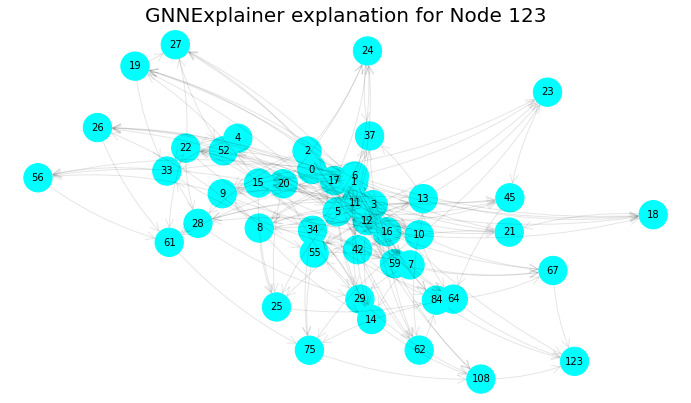

In [23]:
node_idx = 123
# convert to edge format
edges = data['edges'].t().contiguous()

explainer = GNNExplainer(model, epochs=1000, return_type='log_prob', log=True)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data['x'], data['edges'])

ax, G = explainer.visualize_subgraph(node_idx, data['edges'], edge_mask, y=data['y'], threshold=0.8)
plt.title(f"GNNExplainer explanation for Node {node_idx}")
plt.axis('off')
plt.show()

In [24]:
x = data["x"]
edges = data["edges"]
y = data["y"]
train_mask = data["train_mask"]
test_mask = data["test_mask"]
print(test(model, x, y, edges, train_mask))
print(test(model, x, y, edges, test_mask))

0.9875666074600356
0.9635036496350365


In [ ]:
for layer_num, key in enumerate(activation_list):
    print(key)
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    print(activation.shape)

# Dimensionality Reduction

### TSNE

In [ ]:
# TSNE conversion
tsne_models = []
tsne_data = []

for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    tsne_model = TSNE(n_components=2)
    d = tsne_model.fit_transform(activation)
    plot_activation_space(d, labels, "t-SNE reduced", layer_num, paths['TSNE'], "(coloured by labels)")
    
    tsne_models.append(tsne_model)
    tsne_data.append(d)

### PCA

In [ ]:
# PCA conversion
pca_models = []
pca_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pca_model = PCA(n_components=2)
    d = pca_model.fit_transform(activation)
    plot_activation_space(d, labels, "PCA reduced", layer_num, paths['PCA'], "(coloured by labels)")

    pca_models.append(pca_model)
    pca_data.append(d)

### UMAP

In [ ]:
# UMAP conversion
umap_models = []
umap_data = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    umap_model = umap.UMAP(n_components=2)
    d = umap_model.fit_transform(activation)
    plot_activation_space(d, labels, "UMAP reduced", layer_num, paths['UMAP'], "(coloured by labels)")

    umap_models.append(umap_model)
    umap_data.append(d)

# Clustering

### KMeans

##### RAW

In [ ]:
num_nodes_view = 5
num_expansions = 2
edges = data['edge_list'].numpy()

raw_kmeans_sample_feat = []
raw_kmeans_sample_graphs = []
raw_kmeans_models = []
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)
        
    plot_clusters(tsne_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_PCA", "(PCA reduced)")
    plot_clusters(umap_data[layer_num], pred_labels, "k-Means", k, layer_num, paths['KMeans'], "Raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(kmeans_model, activation, data["y"], layer_num, k, "Kmeans", "raw", num_nodes_view, edges, num_expansions, paths['KMeans'])

    raw_kmeans_sample_graphs.append(sample_graphs)
    raw_kmeans_sample_feat.append(sample_feat)
    raw_kmeans_models.append(kmeans_model)
    

##### TSNE

In [ ]:
tsne_kmeans_sample_graphs = []
tsne_kmeans_sample_feat = []
tsne_kmeans_models = []
for layer_num, item in enumerate(tsne_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "t-SNE reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    tsne_kmeans_sample_graphs.append(sample_graphs)
    tsne_kmeans_sample_feat.append(sample_feat)
    tsne_kmeans_models.append(kmeans_model)
    

##### PCA

In [ ]:
pca_kmeans_sample_graphs = []
pca_kmeans_sample_feat = []
pca_kmeans_models = []

for layer_num, item in enumerate(pca_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "PCA reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "PCA reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    pca_kmeans_sample_graphs.append(sample_graphs)
    pca_kmeans_sample_feat.append(sample_feat)
    pca_kmeans_models.append(kmeans_model)

##### UMAP

In [ ]:
umap_kmeans_sample_graphs = []
umap_kmeans_sample_feat = []
umap_kmeans_models = []
for layer_num, item in enumerate(umap_data):
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(item)
    pred_labels = kmeans_model.predict(item)

    plot_clusters(item, pred_labels, "k-Means", k, layer_num, paths['KMeans'], "UMAP reduced")
    sample_graphs, sample_feat = plot_samples(kmeans_model, item, data["y"], layer_num, k, "k-Means", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['KMeans'])

    umap_kmeans_sample_graphs.append(sample_graphs)
    umap_kmeans_sample_feat.append(sample_feat)
    umap_kmeans_models.append(kmeans_model)

#### Heuristics

In [ ]:
# ba_heuristics = BA_Shapes_Heuristics()

# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "raw", paths['KMeans'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "t-SNE reduced", paths['KMeans'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "PCA reduced", paths['KMeans'])

# # for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "k-Means", "UMAP reduced", paths['KMeans'])


### Hierarchical Clustering

##### Raw

In [ ]:
for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    plot_dendrogram(activation, "raw", layer_num, paths['Ward'])

In [ ]:
raw_n_clusters = [4, 6, 23, 14, 30]

raw_hc_sample_graphs = []
raw_hc_sample_feat = []
raw_hc_models = []
for layer_num, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(activation)

    d = (activation, pred_labels)
    plot_clusters(tsne_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_TSNE", "(t-SNE reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_PCA", "(PCA reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "HC-Ward", n, layer_num, paths['Ward'], "raw", "_UMAP", "(UMAP reduced)")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "raw", num_nodes_view, edges, num_expansions, paths['Ward'])

    raw_hc_sample_graphs.append(sample_graphs)
    raw_hc_sample_feat.append(sample_feat)
    raw_hc_models.append(hc)


##### TSNE

In [ ]:
for layer_num, item in enumerate(tsne_data):
    plot_dendrogram(item, "t-SNE", layer_num, paths['Ward'])

In [ ]:
tsne_n_clusters = [5, 4, 30, 13, 7]

tsne_hc_sample_graphs = []
tsne_hc_sample_feat = []
tsne_hc_models = []
for layer_num, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "t-SNE")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

    tsne_hc_sample_graphs.append(sample_graphs)
    tsne_hc_sample_feat.append(sample_feat)
    tsne_hc_models.append(hc)


##### PCA

In [ ]:
for layer_num, item in enumerate(pca_data):
    plot_dendrogram(item, "PCA", layer_num, paths['Ward'])

In [ ]:
pca_n_clusters = [24, 7, 3, 5, 8]

pca_hc_sample_graphs = []
pca_hc_sample_feat = []
pca_hc_models = []
for layer_num, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['HC'], "PCA")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "PCA reduced", num_nodes_view, edges, num_expansions, paths['HC'])

    pca_hc_sample_graphs.append(sample_graphs)
    pca_hc_sample_feat.append(sample_feat)
    pca_hc_models.append(hc)

##### UMAP

In [ ]:
for layer_num, item in enumerate(umap_data):
    plot_dendrogram(item, "UMAP", layer_num, paths['Ward'])

In [ ]:
umap_n_clusters = [10, 24, 30, 30, 30]

umap_hc_sample_graphs = []
umap_hc_sample_feat = []
umap_hc_models = []
for layer_num, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    pred_labels = hc.fit_predict(item)

    d = (item, pred_labels)
    plot_clusters(item, pred_labels, "HC", n, layer_num, paths['Ward'], "UMAP")
    sample_graphs, sample_feat = plot_samples(hc, d, data["y"], layer_num, n, "HC", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['Ward'])

    umap_hc_sample_graphs.append(sample_graphs)
    umap_hc_sample_feat.append(sample_feat)
    umap_hc_models.append(hc)

#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "raw", paths['Ward'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "t-SNE reduced", paths['Ward'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "PCA reduced", paths['Ward'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "HC-Ward", "UMAP reduced", paths['Ward'])


### DBSCAN

##### Raw

In [ ]:
# num_nodes_view = 5
# num_expansions = 2
# edges = data['edge_list'].numpy()

raw_dbscan_sample_feats = []
raw_dbscan_sample_graphs = []
raw_dbscan_models = []
raw_dbscan_ds = []

esp = 0.5
min_samples = 5

for layer_num, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(activation)
    pred_labels = dbscan_model.fit_predict(activation)

    num_cluster = len(np.unique(pred_labels))
    d = (activation, pred_labels)
    raw_dbscan_ds.append(d)

    plot_clusters(tsne_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_TSNE", "(TSNE Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_PCA", "(PCA Reduced)")
    plot_clusters(pca_data[layer_num], pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "Raw", "_UMAP", "(UMAP Reduced)")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "raw", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    raw_dbscan_sample_graphs.append(sample_graphs)
    raw_dbscan_sample_feats.append(sample_feat)
    raw_dbscan_models.append((dbscan_model, num_cluster))


##### TSNE

In [ ]:
tsne_dbscan_sample_graphs = []
tsne_dbscan_sample_feats = []
tsne_dbscan_models = []
tsne_dbscan_ds = []

for layer_num, item in enumerate(tsne_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)
    tsne_dbscan_ds.append(d)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "t-SNE")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "t-SNE reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    tsne_dbscan_sample_graphs.append(sample_graphs)
    tsne_dbscan_sample_feats.append(sample_feat)
    tsne_dbscan_models.append((dbscan_model, num_cluster))


##### PCA

In [ ]:
pca_dbscan_sample_graphs = []
pca_dbscan_sample_feats = []
pca_dbscan_models = []
pca_dbscan_ds = []

for layer_num, item in enumerate(pca_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)
    pca_dbscan_ds.append(d)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "PCA")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "PCA reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    pca_dbscan_sample_graphs.append(sample_graphs)
    pca_dbscan_sample_feats.append(sample_feat)
    pca_dbscan_models.append((dbscan_model, num_cluster))


##### UMAP

In [ ]:
umap_dbscan_sample_graphs = []
umap_dbscan_sample_feats = []
umap_dbscan_models = []
umap_dbscan_ds = []

for layer_num, item in enumerate(umap_data):
    dbscan_model = DBSCAN(eps=esp, min_samples=min_samples)
    dbscan_model = dbscan_model.fit(item)
    pred_labels = dbscan_model.fit_predict(item)

    num_cluster = len(np.unique(pred_labels))
    d = (item, pred_labels)
    umap_dbscan_ds.append(d)

    plot_clusters(item, pred_labels, "DBSCAN", num_cluster, layer_num, paths['DBSCAN'], "UMAP")
    sample_graphs, sample_feat = plot_samples(dbscan_model, d, data["y"], layer_num, num_cluster, "DBSCAN", "UMAP reduced", num_nodes_view, edges, num_expansions, paths['DBSCAN'])

    umap_dbscan_sample_graphs.append(sample_graphs)
    umap_dbscan_sample_feats.append(sample_feat)
    umap_dbscan_models.append((dbscan_model, num_cluster))



#### Heuristics

In [ ]:
# for layer_num, sample in enumerate(raw_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "raw", paths['DBSCAN'])

# for layer_num, sample in enumerate(tsne_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "t-SNE reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(pca_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "PCA reduced", paths['DBSCAN'])

# for layer_num, sample in enumerate(umap_sample_graphs):
#     plot_heuristics_table(ba_heuristics, sample, layer_num, "DBSCAN", "UMAP reduced", paths['DBSCAN'])



# Activation to Concept to Class

### Using KMeans

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "t-SNE")

for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "PCA")

for i, item in enumerate(umap_data):
    activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])

    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "UMAP")

plot_completeness_table("k-Means", "Decision Tree", completeness_scores, paths['KMeans'])

In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "t-SNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "PCA")
    
for i, item in enumerate(umap_data):
    activation_cls = ActivationClassifier(item, umap_kmeans_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths['KMeans'], i, k, "UMAP")
    
plot_completeness_table("k-Means", "Logistic Regression", completeness_scores, paths['KMeans'])
    

### Using Hierarchical Clustering

##### Using Ward

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "raw")
    
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "PCA")
    
for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "UMAP")

plot_completeness_table("HC", "Decision Tree", completeness_scores, paths["Ward"])



In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    activation_cls = ActivationClassifier(activation, raw_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "raw")
    
for i, item in enumerate(tsne_data):
    activation_cls = ActivationClassifier(item, tsne_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "t-SNE")
    
for i, item in enumerate(pca_data):
    activation_cls = ActivationClassifier(item, pca_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "PCA")
    
for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    activation_cls = ActivationClassifier(item, umap_hc_models[i], classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "UMAP")

plot_completeness_table("HC", "Logistic Regression", completeness_scores, paths["Ward"])
    

##### Using DBSCAN

In [ ]:
classifier_str = "decision_tree"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    
    dbscan_model, n = raw_dbscan_models[i]
    activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
for i, item in enumerate(tsne_data):
    dbscan_model, n = tsne_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
for i, item in enumerate(pca_data):
    dbscan_model, n = pca_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["Ward"], i, n, "PCA")
    
for i, item in enumerate(umap_data):
    dbscan_model, n = umap_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

plot_completeness_table("DBSCAN", "Decision Tree", completeness_scores, paths["DBSCAN"])


In [ ]:
classifier_str = "logistic_regression"

completeness_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    dbscan_model, n = raw_dbscan_models[i]
    activation_cls = ActivationClassifier(activation, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "raw")
    
for i, item in enumerate(tsne_data):
    dbscan_model, n = tsne_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["t-SNE reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "t-SNE")
    
for i, item in enumerate(pca_data):
    dbscan_model, n = pca_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["PCA reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "PCA")
    
for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    dbscan_model, n = umap_dbscan_models[i]
    activation_cls = ActivationClassifier(item, dbscan_model, classifier_str, data["x"], data["y"], data["train_mask"], data["test_mask"])
    
    d = ["UMAP reduced", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(d)
    activation_cls.plot(paths["DBSCAN"], i, n, "UMAP")

plot_completeness_table("DBSCAN", "Logistic Regression", completeness_scores, paths["DBSCAN"])
    

# Graph Similarity

In [ ]:
##### KMeans

In [ ]:
graph_scores = []
view = 3
max_num_nodes = 15

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)

    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_kmeans_models[i], activation, data['y'], i, k, "k-Means", "raw", view, edges, num_expansions, paths['KMeans'])
        
        
for i, item in enumerate(tsne_data):    
    distances = get_node_distances(tsne_kmeans_models[i], item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "t-SNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_kmeans_models[i], item, data['y'], i, k, "k-Means", "t-SNE", view, edges, num_expansions, paths['KMeans'])
    
for i, item in enumerate(pca_data):
    distances = get_node_distances(pca_kmeans_models[i], item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_kmeans_models[i], item, data['y'], i, k, "k-Means", "PCA", view, edges, num_expansions, paths['KMeans'])


for i, item in enumerate(umap_data):
    distances = get_node_distances(umap_kmeans_models[i], item)
    
    for k_idx in range(k):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["k-Means", "UMAP", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(umap_kmeans_models[i], item, data['y'], i, k, "k-Means", "UMAP", view, edges, num_expansions, paths['KMeans'])
    
plot_graph_similarity_table("k-Means", graph_scores, paths['KMeans'])
    

In [ ]:
graph_scores = []

for i, (key, n) in enumerate(zip(activation_list, raw_n_clusters)):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    pred_labels = raw_hc_models[i].fit_predict(activation)
    d_item = (activation, pred_labels)
    distances = get_node_distances(raw_hc_models[i], d_item)
    
    for k_idx in range(n):        
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
                
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["HC", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(raw_hc_models[i], d_item, data["y"], i, n, "HC", "raw", view, edges, num_expansions, paths['Ward'])
        
        
for i, (item, n) in enumerate(zip(tsne_data, tsne_n_clusters)): 
    pred_labels = tsne_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(tsne_hc_models[i], d_item)
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["HC", "t-SNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(tsne_hc_models[i], d_item, data["y"], i, n, "HC", "t-SNE", view, edges, num_expansions, paths['Ward'])
        

        
for i, (item, n) in enumerate(zip(pca_data, pca_n_clusters)):
    pred_labels = pca_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(pca_hc_models[i], d_item)

    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["HC", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(pca_hc_models[i], d_item, data["y"], i, n, "HC", "PCA", view, edges, num_expansions, paths['Ward'])
    

for i, (item, n) in enumerate(zip(umap_data, umap_n_clusters)):
    pred_labels = umap_hc_models[i].fit_predict(item)
    d_item = (item, pred_labels)
    distances = get_node_distances(umap_hc_models[i], d_item)

    for k_idx in range(n):
        top_indices = np.argsort(distances[k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["HC", "UMAP", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(umap_hc_models[i], d_item, data["y"], i, n, "HC", "UMAP", view, edges, num_expansions, paths['Ward'])
        
    
plot_graph_similarity_table("HC", graph_scores, paths['Ward'])
    

In [ ]:
graph_scores = []

for i, key in enumerate(activation_list):
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    
    dbscan_model, n = raw_dbscan_models[i]
    distances = get_node_distances(dbscan_model, raw_dbscan_ds[i])

    for k_idx in range(n):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["DBSCAN", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(dbscan_model, raw_dbscan_ds[i], data['y'], i, n, "DBSCAN", "raw", view, edges, num_expansions, paths['DBSCAN'])
        
for i, item in enumerate(tsne_data):  
    dbscan_model, n = tsne_dbscan_models[i]
    distances = get_node_distances(dbscan_model, tsne_dbscan_ds[i])
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)

        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["DBSCAN", "t-SNE", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(dbscan_model, tsne_dbscan_ds[i], data['y'], i, n, "DBSCAN", "t-SNE", view, edges, num_expansions, paths['DBSCAN'])
    
for i, item in enumerate(pca_data):
    dbscan_model, n = pca_dbscan_models[i]
    distances = get_node_distances(dbscan_model, pca_dbscan_ds[i])
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["DBSCAN", "PCA", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(dbscan_model, pca_dbscan_ds[i], data['y'], i, n, "DBSCAN", "PCA", view, edges, num_expansions, paths['DBSCAN'])


for i, item in enumerate(umap_data):
    dbscan_model, n = umap_dbscan_models[i]
    distances = get_node_distances(dbscan_model, umap_dbscan_ds[i])
    
    for k_idx in range(n):
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices, data['y'], edges, num_expansions)
        
        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)
        
        d = ["DBSCAN", "UMAP", str(i), str(k_idx), str(score)]
        graph_scores.append(d)
        
    plot_samples(dbscan_model, umap_dbscan_ds[i], data['y'], i, n, "DBSCAN", "UMAP", view, edges, num_expansions, paths['DBSCAN'])
    
plot_graph_similarity_table("DBSCAN", graph_scores, paths['DBSCAN'])
    

# GNNExplainer

In [ ]:
node_idx = 514

In [ ]:
# Explain using k-Means
edges = data['edge_list'].numpy()

# get predicted cluster label - visualise top representations in cluster
activation_key = 'conv3'
layer_idx = 3

# get concept number
activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
concepts = raw_kmeans_models[layer_idx].predict(activations) 

# get top example for concept/cluster
concept = concepts[node_idx]
top_graph = raw_kmeans_sample_graphs[layer_idx][concept][0]
color_map = raw_kmeans_sample_feat[layer_idx][concept]

fig, ax = plt.subplots()
nx.draw(top_graph, node_color=color_map, with_labels=True, ax=ax)
ax.set_title(f"Top Example of Concept extracted using k-Means for Node {node_idx}")
plt.show()

# get closest concept representations to what trying to explain
indices_in_cluster = np.argwhere(concepts == concept).flatten()
clustered_activations = activations[indices_in_cluster]

from sklearn.neighbors import NearestNeighbors
nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

neighbours = indices_in_cluster[neighbours[1]].flatten()
tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
fig.suptitle(f"Nearest Concept representations extacted using k-Means for Node {node_idx}")
for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
    nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
    ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# node_idx = 698

# get predicted cluster label - visualise top representations in cluster
activation_layer = 'conv3'
layer_idx = 3
n = 14

# get top surrouning examples
activations = torch.squeeze(activation_list[activation_key]).detach().numpy()
hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
concepts = hc.fit_predict(activations)

d = (activations, concepts)

concept = concepts[node_idx]

def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
    res_sorted = get_node_distances(clustering_model, data)
    
    if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
        print(res_sorted.shape)
        distances = res_sorted[cluster_num]
    elif isinstance(clustering_model, KMeans):
        distances = res_sorted[:, cluster_num]
            
    top_index = np.argsort(distances)[::][0]
    tg, cm, labels, _ = get_top_subgraphs([top_index], y, edges, num_expansions)

    fig, ax = plt.subplots()
    fig.suptitle(f"Top Example of Concept extracted using HC for Node {node_idx}")
    
    nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
    ax.set_title(f"label {labels[0]}", fontsize=14)

    
edges = data['edge_list'].numpy()
# get top example for concept/cluster
get_top_example(hc, d, data['y'], edges, concept, num_expansions)

# get closest concept representations to what trying to explain
indices_in_cluster = np.argwhere(concepts == concept).flatten()
clustered_activations = activations[indices_in_cluster]

from sklearn.neighbors import NearestNeighbors
nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

neighbours = indices_in_cluster[neighbours[1]].flatten()
tg, cm, labels, _ = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
fig.suptitle(f"Nearest Concept representations extacted using HC for Node {node_idx}")
for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
    nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
    ax.set_title(f"label {l}", fontsize=14)

In [ ]:
# # node_idx = 698

# # Explain using DBSCAN
# eps = 0.1
# min_samples = 3

# # get predicted cluster label - visualise top representations in cluster
# activation_layer = 2
# layer_idx = 3

# # get top surrouning examples
# activations = umap_data[activation_layer]
# dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
# concepts = dbscan_model.fit_predict(activations)

# num_cluster = len(np.unique(concepts))
# print("Num clusters: ", num_cluster)
# d = (activations, concepts)

# concept = concepts[node_idx]

# def get_top_example(clustering_model, data, y, edges, cluster_num, num_expansions):
#     res_sorted = get_node_distances(clustering_model, data)
    
#     if isinstance(clustering_model, AgglomerativeClustering) or isinstance(clustering_model, DBSCAN):
#         print(res_sorted.shape)
#         distances = res_sorted[cluster_num]
#     elif isinstance(clustering_model, KMeans):
#         distances = res_sorted[:, cluster_num]
            
#     top_index = np.argsort(distances)[::][0]
#     tg, cm, labels = get_top_subgraphs([top_index], y, edges, num_expansions)

#     fig, ax = plt.subplots()
#     fig.suptitle("Top Example of Concept extracted using DBSCAN for Node 462")
    
#     nx.draw(tg[0], node_color=cm[0], with_labels=True, ax=ax)
#     ax.set_title(f"label {labels[0]}", fontsize=14)

    
# edges = data['edge_list'].numpy()
# # get top example for concept/cluster
# get_top_example(dbscan_model, d, data['y'], edges, concept, 1)

# # get closest concept representations to what trying to explain
# indices_in_cluster = np.argwhere(concepts == concept).flatten()
# clustered_activations = activations[indices_in_cluster]

# from sklearn.neighbors import NearestNeighbors
# nearest_neighbours = NearestNeighbors(n_neighbors=5).fit(clustered_activations)
# neighbours = nearest_neighbours.kneighbors(np.expand_dims(activations[node_idx], axis=0), 5)

# neighbours = indices_in_cluster[neighbours[1]].flatten()
# tg, cm, labels = get_top_subgraphs(neighbours, data['y'], edges, num_expansions)

# fig, axs = plt.subplots(1, len(neighbours), figsize=(14, 6))
# fig.suptitle("Nearest Concept representations extacted using DBSCAN for Node 462")
# for i, (g, c, l) in enumerate(zip(tg, cm, labels)):
#     nx.draw(g, node_color=c, with_labels=True, ax=axs[i])
#     ax.set_title(f"label {label}", fontsize=14)

In [ ]:
# convert to edge format
edges = data['edges'].t().contiguous()

explainer = GNNExplainer(model, epochs=1000, return_type='log_prob', log=True)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data['x'], data['edges'])

ax, G = explainer.visualize_subgraph(node_idx, data['edges'], edge_mask, y=data['y'], threshold=0.8)
plt.title(f"GNNExplainer explanation for Node {node_idx}")
plt.axis('off')
plt.show()